In [1]:
!pip install pandas

In [2]:
import pandas as pd


In [3]:
!pip install sqlalchemy

In [4]:
import sqlalchemy
print("SQLAlchemy imported successfully.")

SQLAlchemy imported successfully.


In [5]:
!pip install psycopg2-binary

In [6]:
import psycopg2
print("psycopg2 imported successfully.")

psycopg2 imported successfully.


In [7]:
!pip install matplotlib

In [8]:
import matplotlib
print("matplotlib imported successfully.")

matplotlib imported successfully.


In [9]:
!pip install seaborn

In [10]:
import seaborn
print("seaborn imported successfully.")

seaborn imported successfully.


In [11]:
!pip install statsmodels

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
print("statsmodels and SARIMAX imported successfully.")


statsmodels and SARIMAX imported successfully.


In [38]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import sys
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set matplotlib to display plots inline in the notebook
%matplotlib inline

# --- Database Configuration ---
db_user = 'postgres'
db_pass = 'anzirsql' # Your password
db_host = 'localhost'
db_port = '5432'
db_name = 'sales_analysis'

# --- File Paths ---
# Using raw strings (r"...") for your Windows paths
store_csv_path = r"F:\NSU\Projects Datasets\sales project\rossmann-store-sales\store.csv"
train_csv_path = r"F:\NSU\Projects Datasets\sales project\rossmann-store-sales\train.csv"

# Create the connection string
conn_string = f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}'

print("All packages imported and configuration loaded.")

All packages imported and configuration loaded.


In [16]:
# Check if files exist
if not os.path.exists(store_csv_path):
    print(f"Error: '{store_csv_path}' not found.")
elif not os.path.exists(train_csv_path):
    print(f"Error: '{train_csv_path}' not found.")
else:
    print("All CSV files found successfully.")

# Create the database engine and test the connection
try:
    engine = create_engine(conn_string)
    with engine.connect() as conn:
        print("Connection to PostgreSQL database 'sales_analysis' was successful.")
except Exception as e:
    print(f"Error connecting to database: {e}")
    print("--- PLEASE CHECK YOUR PASSWORD AND THAT POSTGRESQL IS RUNNING ---")

All CSV files found successfully.
Connection to PostgreSQL database 'sales_analysis' was successful.


In [18]:
from sqlalchemy import text
print("`text` function imported successfully.")

`text` function imported successfully.


In [20]:
print("--- Starting Data Loading (Corrected for Case-Sensitivity) ---")

# --- Load store.csv ---
try:
    with engine.connect() as conn:
        # Check if the table is empty first
        result = conn.execute(text("SELECT COUNT(*) FROM stores")).scalar()
    
    if result == 0:
        print("Loading store.csv...")
        df_store = pd.read_csv(store_csv_path)
        
        # --- THIS IS THE FIX ---
        # Convert all column names to lowercase to match the database
        df_store.columns = df_store.columns.str.lower()
        # --- End of FIX ---

        df_store.to_sql('stores', engine, if_exists='append', index=False)
        print("Successfully loaded store.csv into 'stores' table.")
    else:
        print(f"'stores' table already contains {result} rows. Skipping store.csv.")
except Exception as e:
    print(f"Error loading store.csv: {e}")

--- Starting Data Loading (Corrected for Case-Sensitivity) ---
Loading store.csv...
Successfully loaded store.csv into 'stores' table.


In [37]:
# --- Load train.csv (in chunks) ---
try:
    with engine.connect() as conn:
        # Check if the table is empty first
        result = conn.execute(text("SELECT COUNT(*) FROM sales")).scalar()
    
    if result == 0:
        print("Loading train.csv in chunks (this may take 5-10 minutes)...")
        
        # Read the file in chunks of 100,000 rows
        chunk_iter = pd.read_csv(train_csv_path, chunksize=100000, low_memory=False)
        
        for i, chunk in enumerate(chunk_iter):
            # --- THIS IS THE FIX ---
            # Convert all column names to lowercase to match the database
            chunk.columns = chunk.columns.str.lower()
            # --- End of FIX ---

            chunk.to_sql('sales', engine, if_exists='append', index=False)
            print(f"Loaded chunk {i+1} into 'sales' table.")
        
        print("Successfully loaded all chunks of train.csv.")
    else:
        print(f"'sales' table already contains {result} rows. Skipping train.csv.")
except Exception as e:
    print(f"Error loading train.csv: {e}")

'sales' table already contains 1017209 rows. Skipping train.csv.


In [35]:
print("Loading data from PostgreSQL into pandas DataFrame")
print("Query joins 'sales' and 'stores'")

# SQL query to join the two tables
# This works because all columns are now lowercase
sql_query = """
SELECT * FROM sales 
JOIN stores ON sales.store = stores.store;
"""

try:
    df = pd.read_sql_query(sql_query, engine)
    print(f"Data loaded successfully. Total rows: {len(df)}")
    
    if df.empty:
        print("Error: The DataFrame is empty. No data was loaded.")
    else:
        # display() is a jupyter-specific function to pretty-print the table
        print("Displaying first 5 rows of the joined data:")
        display(df.head())
        
except Exception as e:
    print(f"Error loading data from database: {e}")

Loading data from PostgreSQL into pandas DataFrame
Query joins 'sales' and 'stores'
Data loaded successfully. Total rows: 1017209
Displaying first 5 rows of the joined data:


,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
1,2,5,2015-07-31,6064,625,1,1,0,1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,None
4,5,5,2015-07-31,4822,559,1,1,0,1,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,None


In [34]:
print("Starting data cleaning and feature engineering")

# Convert date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Fill missing CompetitionDistance with the median
median_comp_dist = df['competitiondistance'].median()
df['competitiondistance'].fillna(median_comp_dist, inplace=True)

# Fill other NaNs with 0 (for promo intervals, etc.)
df.fillna(0, inplace=True)

# Feature Engineering: Create new time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekofyear'] = df['date'].dt.isocalendar().week

# Feature Engineering: Calculate Sales per Customer
df['salespercustomer'] = 0
# Use .loc to avoid a common warning
df.loc[df['customers'] > 0, 'salespercustomer'] = df['sales'] / df['customers']

print("Data cleaning and feature engineering complete.")
print("Data head with new features:")
display(df.head())

Starting data cleaning and feature engineering
Data cleaning and feature engineering complete.
Data head with new features:


,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,store,...,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval,year,month,weekofyear,salespercustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,1,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,3,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,4,...,9.0,2009.0,0,0.0,0.0,0,2015,7,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,5,...,4.0,2015.0,0,0.0,0.0,0,2015,7,31,8.626118


Generating Plot 1: Total Monthly Sales Over Time


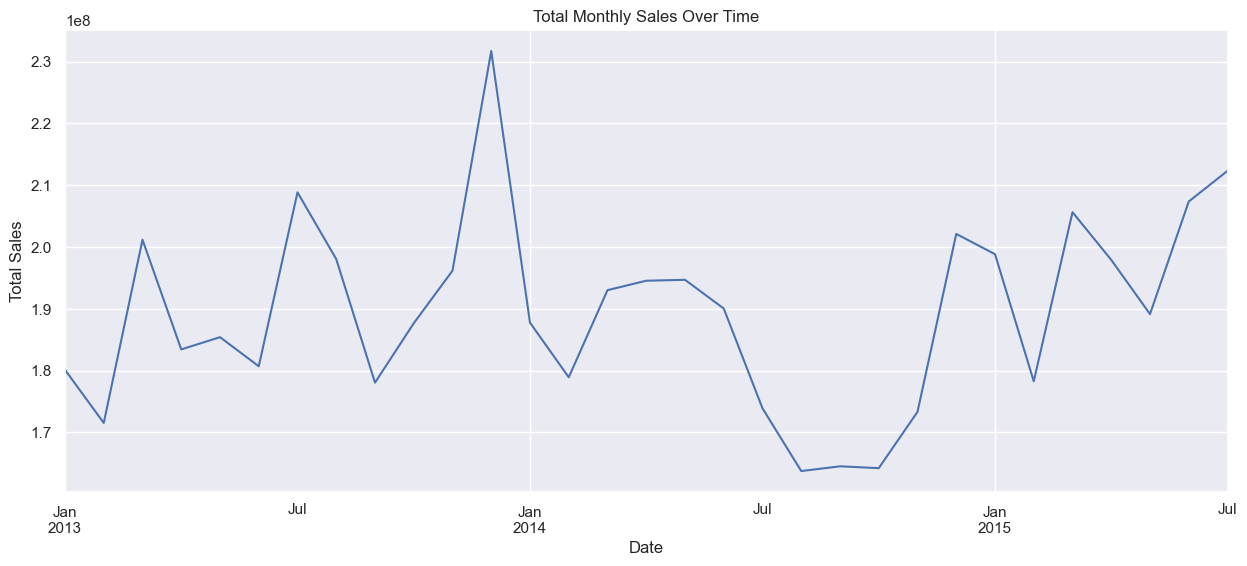

In [25]:
print("Generating Plot 1: Total Monthly Sales Over Time")
sns.set(style="darkgrid") # Sets a nice-looking grid style for the plot

# Resample to monthly sales by summing up all sales for each month
df_monthly_sales = df.set_index('date')['sales'].resample('M').sum()

# Plot
plt.figure(figsize=(15, 6)) # Make the plot wide
plt.title("Total Monthly Sales Over Time")
df_monthly_sales.plot()
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show() # This command displays the plot in your notebook

Generating Plot 2: Average Sales by Day of Week


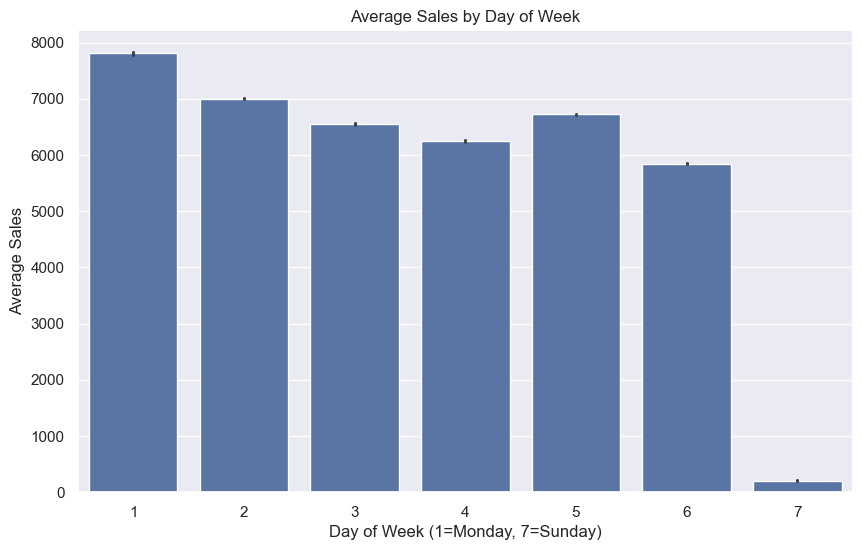

In [27]:
print("Generating Plot 2: Average Sales by Day of Week")

plt.figure(figsize=(10, 6)) # Set the figure size
# Create a bar plot using seaborn
sns.barplot(data=df, x='dayofweek', y='sales')
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (1=Monday, 7=Sunday)")
plt.ylabel("Average Sales")
plt.show()

In [28]:
print("Preparing time series data for forecasting...")

# 1. Filter for days when stores were open and had sales
df_ts = df[(df['open'] == 1) & (df['sales'] > 0)]

# 2. Group all sales by date to get one total sales number per day
df_daily = df_ts.groupby('date')['sales'].sum()

# 3. Resample to weekly sums. 'W' stands for 'Weekly'.
# This adds up all sales for each week, giving us a smoother trend.
df_weekly = df_daily.resample('W').sum()

print("Time series data prepared (resampled to weekly).")
print("Displaying the last 5 weeks of data to be forecasted:")
display(df_weekly.tail())

Preparing time series data for forecasting...
Time series data prepared (resampled to weekly).
Displaying the last 5 weeks of data to be forecasted:


date
2015-07-05    55690481
2015-07-12    41391282
2015-07-19    52008419
2015-07-26    39402115
2015-08-02    47230923
Freq: W-SUN, Name: sales, dtype: int64

In [32]:
print("Training SARIMA model")

try:
    # We use a seasonal order of 52 because there are 52 weeks in a year
    # (p,d,q) = (1,1,1) is a common starting point for the non-seasonal part
    # (P,D,Q,s) = (1,1,1,52) is for the seasonal part
    model = SARIMAX(df_weekly, 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 52),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    # .fit() is the command that starts the training
    results = model.fit(disp=False) # disp=False hides a lot of log messages
    
    print("Model training complete.")
    
    # Optional: uncomment the line below if you want to see the model's statistical summary
    # print(results.summary())
    
except Exception as e:
    print(f"Error training SARIMA model: {e}")

Training SARIMA model
Model training complete.


In [31]:
print("Generating 52-week forecast...")
forecast_steps = 52
forecast_obj = results.get_forecast(steps=forecast_steps)

# Get the predicted sales and put them in a DataFrame
# .predicted_mean is the most likely forecast value
forecast_df = forecast_obj.predicted_mean.to_frame(name='forecasted_sales')

print("Forecast generated. Displaying first 5 predicted weeks:")
display(forecast_df.head())

print("\nSaving forecast to PostgreSQL table 'sales_forecast'...")
try:
    # Save to SQL. 'if_exists='replace'' will create a new table
    # or overwrite it if it already exists.
    # 'index=True' saves the dates (which are the index) as a new column.
    forecast_df.to_sql('sales_forecast', engine, if_exists='replace', index=True)
    print("Forecast successfully saved to 'sales_forecast' table.")
except Exception as e:
    print(f"Error saving forecast to database: {e}")

Generating 52-week forecast...
Forecast generated. Displaying first 5 predicted weeks:


,forecasted_sales
2015-08-09,4.810581e+07
2015-08-16,4.042336e+07
2015-08-23,4.791214e+07
2015-08-30,4.161004e+07
2015-09-06,4.845598e+07



Saving forecast to PostgreSQL table 'sales_forecast'...
Forecast successfully saved to 'sales_forecast' table.
